In [1]:
import pandas as pd
import numpy as np
import os

#ML Packages
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Load Processed Dataset & Labels

In [2]:
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")

    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []

    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))

    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]

    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array

    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [3]:
class LabeledExtractor:
    """
    Adapted extractor for labeled medical imaging dataset to meet new pydicom requirements
    """
    def __init__(self,
                 labels_csv_path,
                 dicom_base_dir,
                 dst_path,
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TB', 'TM'],
                 augment=True):
        """
        Args:
            labels_csv_path: Path to labels file
            dicom_base_dir: Base directory containing DICOM scans organized by uuid
            dst_path: Where to save the processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation
        """
        self.labels_csv_path = labels_csv_path
        self.dicom_base_dir = dicom_base_dir
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment

        # Load and filter the labels
        self.labels_df = pd.read_csv(labels_csv_path)
        self.labels_df = self.labels_df[self.labels_df['type'].isin(include_types)]

        # # Filter out TB entries with 0,0,0 coordinates (no specific location)
        # self.labels_df = self.labels_df[~((self.labels_df['type'] == 'TB') &
        #                                 (self.labels_df['x'] == 0) &
        #                                 (self.labels_df['y'] == 0) &
        #                                 (self.labels_df['slice'] == 0))]

        print(f"Loaded {len(self.labels_df)} labeled samples")
        print(f"Types distribution:\n{self.labels_df['type'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples"""
        print("Preparing extraction jobs...")

        jobs = []
        labels = []

        for idx, row in self.labels_df.iterrows():
            # Build path to DICOM scan
            scan_path = os.path.join(self.dicom_base_dir, str(row['uuid']))

            # Coordinate in z,y,x format (slice, y, x)
            coord = np.array([row['slice'], row['y'], row['x']])

            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type']])
            labels.append(row['type'])

        print(f"Extracting {len(jobs)} samples...")

        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)

        # Collect successful extractions
        instances = []
        instance_labels = []

        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))

        instances = np.array(instances)
        instance_labels = np.array(instance_labels)

        if len(instances) == 0:
            print("ERROR: No instances were successfully extracted!")
            print("This could be due to:")
            print("1. DICOM loading issues")
            print("2. Coordinate problems")
            print("3. Missing DICOM files")
            return None, None, None

        print(f"Successfully extracted {len(instances)} instances")

        # Preprocessing
        print("Equalizing the data...")
        eq = histEq(instances)
        instances = eq.equalize(instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(instances)
        max_v = np.max(instances)
        mean_v = np.mean(instances)
        norm_data = np.array([mean_v, min_v, max_v])
        instances = (instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)

        if plot:
            self._plot_samples(instances, instance_labels)

        # Save dataset and labels
        print("Saving the dataset...")
        np.save(self.dst_path, instances)
        np.save(self.dst_path.replace('.npy', '_labels.npy'), instance_labels)

        # Create label mapping
        label_mapping = {label: idx for idx, label in enumerate(np.unique(instance_labels))}
        print(f"Label mapping: {label_mapping}")

        return instances, instance_labels, label_mapping

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type = args

        try:
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)

            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)

            # Extract the base cube with padding
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)

            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)

            # Data augmentation
            if self.augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]

            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):  # Only keep properly shaped cubes
                    final_cubes.append(final_cube)

            return final_cubes, label_type

        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation similar to original code but simplified"""
        augmented = [x0]  # Original

        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip

        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))

        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)

        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)

        return valid_cubes

    def _plot_samples(self, instances, labels):
        """Plot sample instances with their labels"""
        import matplotlib.pyplot as plt

        # Select random samples from each class
        unique_labels = np.unique(labels)
        samples_per_class = min(5, len(instances) // len(unique_labels))

        fig, axes = plt.subplots(len(unique_labels), samples_per_class,
                                figsize=(samples_per_class * 3, len(unique_labels) * 3))

        if len(unique_labels) == 1:
            axes = axes.reshape(1, -1)

        for i, label in enumerate(unique_labels):
            label_indices = np.where(labels == label)[0]
            selected_indices = np.random.choice(label_indices,
                                              min(samples_per_class, len(label_indices)),
                                              replace=False)

            for j, idx in enumerate(selected_indices):
                middle_slice = instances[idx].shape[0] // 2
                axes[i, j].imshow(instances[idx][middle_slice, :, :], cmap='bone')
                axes[i, j].set_title(f'{label}')
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.suptitle('Sample Extracted Instances by Type')
        plt.show()

In [4]:
class LabeledDataLoader:
    """
    Data loader for labeled dataset - modified for classification
    """
    def __init__(self, dataset_path, labels_path, normdata_path, img_res=(32, 32, 32)):
        self.normdata_path = normdata_path
        self.img_res = img_res

        print("Loading preprocessed dataset...")
        self.data = np.load(dataset_path)
        self.labels = np.load(labels_path)

        # Create label mapping
        self.unique_labels = np.unique(self.labels)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        # Convert labels to indices
        self.label_indices = np.array([self.label_to_idx[label] for label in self.labels])

        # Format for neural network
        self.data = self.data.reshape((len(self.data), self.img_res[0], self.img_res[1], self.img_res[2], 1))

        print(f"Loaded {len(self.data)} samples")
        print(f"Label distribution: {dict(zip(*np.unique(self.labels, return_counts=True)))}")

    def load_batch(self, batch_size=32, shuffle=True):
        """Load batches for training"""
        if shuffle:
            indices = np.random.permutation(len(self.data))
        else:
            indices = np.arange(len(self.data))

        n_batches = len(self.data) // batch_size

        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = self.data[batch_indices]
            batch_labels = self.label_indices[batch_indices]

            yield batch_data, batch_labels

In [5]:
def create_eda_dataframe(labels_csv_path, processed_data_path=None, processed_labels_path=None):
    """
    Create dataframe for EDA
    """
    # Load original labels CSV
    print("Loading original labels...")
    df_filtered = pd.read_csv(labels_csv_path)

    # # Filter out TB entries with 0,0,0 coordinates
    # df_filtered = df_original[df_original['type'].isin(['FB', 'FM', 'TM'])]
    # df_filtered = df_filtered[~((df_filtered['type'] == 'TB') &
    #                           (df_filtered['x'] == 0) &
    #                           (df_filtered['y'] == 0) &
    #                           (df_filtered['slice'] == 0))]

    #print(f"Original labels: {len(df_original)}")
    print(f"After filtering: {len(df_filtered)}")

    # Add encoded labels for visualization
    le = LabelEncoder()
    df_filtered['type_encoded'] = le.fit_transform(df_filtered['type'])

    # add augmentation info
    if processed_data_path and processed_labels_path:
        try:
            processed_labels = np.load(processed_labels_path)
            print(f"Processed dataset size: {len(processed_labels)}")

            # Calculate augmentation factor
            augmentation_factor = len(processed_labels) / len(df_filtered)
            df_filtered['augmentation_factor'] = augmentation_factor

        except FileNotFoundError:
            print("Processed data not found, using original data only")
            df_filtered['augmentation_factor'] = 1

    return df_filtered, le

def plot_class_distribution(df):
    """Create class distribution bar plot"""
    plt.figure(figsize=(10, 6))

    # Count by class
    class_counts = df['type'].value_counts()
    classes = class_counts.index
    counts = class_counts.values

    # Color scheme
    colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1'}
    plot_colors = [colors[cls] for cls in classes]

    # Create bar plot
    bars = plt.bar(classes, counts, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    # Styling
    plt.title('Distribution of Tamper Types in Dataset', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Tamper Classification', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Instances', fontsize=12, fontweight='bold')

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

    # Add percentage labels
    total = sum(counts)
    for bar, count in zip(bars, counts):
        percentage = (count/total) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                f'{percentage:.1f}%', ha='center', va='center',
                fontweight='bold', fontsize=10, color='white')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\\n=== Class Distribution Statistics ===")
    for cls in classes:
        count = class_counts[cls]
        pct = (count/total) * 100
        print(f"{cls}: {count} instances ({pct:.1f}%)")

def plot_spatial_distribution(df):
    """Create 3D spatial distribution visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Color mapping for tamper types
    colors = {'FB': 0, 'FM': 1, 'TM': 2}
    df['color_code'] = df['type'].map(colors)

    # 1. X-Y plane distribution (axial view)
    scatter1 = axes[0,0].scatter(df['x'], df['y'], c=df['color_code'],
                                cmap='viridis', alpha=0.7, s=50, edgecolors='black')
    axes[0,0].set_xlabel('X Coordinate (Left-Right)', fontsize=10, fontweight='bold')
    axes[0,0].set_ylabel('Y Coordinate (Anterior-Posterior)', fontsize=10, fontweight='bold')
    axes[0,0].set_title('Tamper Locations in X-Y Plane (Axial View)', fontsize=12, fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)

    # 2. X-Z plane distribution (coronal view)
    scatter2 = axes[0,1].scatter(df['x'], df['slice'], c=df['color_code'],
                                cmap='viridis', alpha=0.7, s=50, edgecolors='black')
    axes[0,1].set_xlabel('X Coordinate (Left-Right)', fontsize=10, fontweight='bold')
    axes[0,1].set_ylabel('Z Coordinate (Slice Number)', fontsize=10, fontweight='bold')
    axes[0,1].set_title('Tamper Locations in X-Z Plane (Coronal View)', fontsize=12, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Y-Z plane distribution (sagittal view)
    scatter3 = axes[1,0].scatter(df['y'], df['slice'], c=df['color_code'],
                                cmap='viridis', alpha=0.7, s=50, edgecolors='black')
    axes[1,0].set_xlabel('Y Coordinate (Anterior-Posterior)', fontsize=10, fontweight='bold')
    axes[1,0].set_ylabel('Z Coordinate (Slice Number)', fontsize=10, fontweight='bold')
    axes[1,0].set_title('Tamper Locations in Y-Z Plane (Sagittal View)', fontsize=12, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)

    # 4. 3D histogram
    axes[1,1].hist2d(df['x'], df['y'], bins=20, cmap='Blues', alpha=0.8)
    axes[1,1].set_xlabel('X Coordinate', fontsize=10, fontweight='bold')
    axes[1,1].set_ylabel('Y Coordinate', fontsize=10, fontweight='bold')
    axes[1,1].set_title('Spatial Density Heatmap', fontsize=12, fontweight='bold')

    # Add colorbar for tamper types
    cbar = plt.colorbar(scatter1, ax=axes[0,0], ticks=[0, 1, 2])
    cbar.set_ticklabels(['FB', 'FM', 'TM'])
    cbar.set_label('Tamper Type', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print spatial statistics
    print("\\n=== Spatial Distribution Statistics ===")
    for coord in ['x', 'y', 'slice']:
        print(f"{coord.upper()} coordinate:")
        print(f"  Range: [{df[coord].min()}, {df[coord].max()}]")
        print(f"  Mean: {df[coord].mean():.1f} ± {df[coord].std():.1f}")
        print(f"  Median: {df[coord].median():.1f}")

def plot_correlation_analysis(df):
    """Create correlation analysis visualization"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Correlation heatmap
    coords = ['x', 'y', 'slice']
    corr_matrix = df[coords].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, ax=axes[0], cbar_kws={'label': 'Correlation Coefficient'})
    axes[0].set_title('Spatial Coordinate Correlations', fontsize=14, fontweight='bold')

    # 2. Pairwise relationships
    # Create subplot for pairwise scatter
    axes[1].scatter(df['x'], df['y'], alpha=0.6, s=30, label='X vs Y')
    axes[1].set_xlabel('X Coordinate', fontweight='bold')
    axes[1].set_ylabel('Y Coordinate', fontweight='bold')
    axes[1].set_title('X-Y Coordinate Relationship', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(df['x'], df['y'], 1)
    p = np.poly1d(z)
    axes[1].plot(df['x'], p(df['x']), "r--", alpha=0.8,
                label=f'Trend (r={corr_matrix.loc["x", "y"]:.3f})')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Print correlation insights
    print("\\n=== Correlation Analysis ===")
    print("Correlation coefficients:")
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            corr_val = corr_matrix.iloc[i, j]
            coord1, coord2 = coords[i], coords[j]
            strength = "weak" if abs(corr_val) < 0.3 else "moderate" if abs(corr_val) < 0.7 else "strong"
            print(f"  {coord1.upper()}-{coord2.upper()}: {corr_val:.3f} ({strength})")

def plot_class_characteristics(df):
    """Analyze characteristics by tamper type"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Box plots for each coordinate by class
    coords = ['x', 'y', 'slice']
    for i, coord in enumerate(coords):
        if i < 3:  # We have 3 coordinates but 4 subplots
            row, col = divmod(i, 2)
            data_by_class = [df[df['type'] == cls][coord].values for cls in ['FB', 'FM', 'TM']]

            bp = axes[row, col].boxplot(data_by_class, labels=['FB', 'FM', 'TM'],
                                       patch_artist=True, notch=True)

            # Color the boxes
            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            axes[row, col].set_title(f'{coord.upper()} Coordinate by Tamper Type',
                                   fontweight='bold', fontsize=12)
            axes[row, col].set_ylabel(f'{coord.upper()} Value', fontweight='bold')
            axes[row, col].grid(True, alpha=0.3)

    # Patient distribution (UUID analysis)
    uuid_counts = df['uuid'].value_counts()
    axes[1, 1].hist(uuid_counts.values, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].set_title('Tamper Instances per Patient', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Number of Tamper Sites per Patient', fontweight='bold')
    axes[1, 1].set_ylabel('Number of Patients', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print class statistics
    print("\\n=== Class-Specific Statistics ===")
    for tamper_type in ['FB', 'FM', 'TB', 'TM']:
        subset = df[df['type'] == tamper_type]
        print(f"\\n{tamper_type} ({len(subset)} instances):")
        print(f"  Unique patients: {subset['uuid'].nunique()}")
        print(f"  Avg instances per patient: {len(subset)/subset['uuid'].nunique():.2f}")
        for coord in ['x', 'y', 'slice']:
            print(f"  {coord.upper()}: {subset[coord].mean():.1f} ± {subset[coord].std():.1f}")

def create_augmentation_visualization(original_data_path, augmented_data_path, labels_path):
    """Show before/after augmentation if data available"""
    try:
        original_data = np.load(original_data_path) if original_data_path else None
        augmented_data = np.load(augmented_data_path)
        labels = np.load(labels_path)

        # Sample one from each class
        fig, axes = plt.subplots(3, 6, figsize=(18, 9))

        unique_labels = np.unique(labels)
        for class_idx, label in enumerate(unique_labels):
            class_indices = np.where(labels == label)[0]
            sample_idx = class_indices[0]  # First sample of this class

            # Show original
            sample_cube = augmented_data[sample_idx]
            middle_slice = sample_cube.shape[0] // 2

            axes[class_idx, 0].imshow(sample_cube[middle_slice, :, :], cmap='bone')
            axes[class_idx, 0].set_title(f'{label} - Original')
            axes[class_idx, 0].axis('off')

            # Show some augmented versions
            augmentation_names = ['Example 2', 'Example 3', 'Example 4', 'Example 5', 'Example 6']
            for aug_idx in range(1, 6):
                if sample_idx + aug_idx < len(class_indices):
                    aug_sample_idx = class_indices[sample_idx + aug_idx] if sample_idx + aug_idx < len(class_indices) else class_indices[-1]
                    aug_cube = augmented_data[aug_sample_idx]
                    axes[class_idx, aug_idx].imshow(aug_cube[middle_slice, :, :], cmap='bone')
                    axes[class_idx, aug_idx].set_title(f'{label} - {augmentation_names[aug_idx-1]}')
                else:
                    axes[class_idx, aug_idx].text(0.5, 0.5, 'N/A', ha='center', va='center', transform=axes[class_idx, aug_idx].transAxes)
                axes[class_idx, aug_idx].axis('off')

        plt.suptitle('Sample Images by Tamper Type', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f"\\n=== Augmentation Statistics ===")
        print(f"Final dataset size: {len(augmented_data)} cubes")
        print(f"Augmentation factor: {len(augmented_data) / len(np.unique(labels))} per unique label")

    except FileNotFoundError:
        print("Augmented data files not found. Skipping augmentation visualization.")

def run_complete_eda(labels_csv_path, processed_data_path=None, processed_labels_path=None):
    """
    Run complete EDA pipeline
    """
    print("=== MEDICAL IMAGE TAMPER DETECTION - EDA ===\\n")

    # Create dataframe
    df, label_encoder = create_eda_dataframe(labels_csv_path, processed_data_path, processed_labels_path)

    print(f"\\nDataset loaded successfully!")
    print(f"Total instances: {len(df)}")
    print(f"Unique patients: {df['uuid'].nunique()}")
    print(f"Tamper types: {df['type'].unique()}")

    # Run all visualizations
    print("\\n" + "="*50)
    print("1. CLASS DISTRIBUTION ANALYSIS")
    print("="*50)
    plot_class_distribution(df)

    print("\\n" + "="*50)
    print("2. SPATIAL DISTRIBUTION ANALYSIS")
    print("="*50)
    plot_spatial_distribution(df)

    print("\\n" + "="*50)
    print("3. CORRELATION ANALYSIS")
    print("="*50)
    plot_correlation_analysis(df)

    print("\\n" + "="*50)
    print("4. CLASS CHARACTERISTICS")
    print("="*50)
    plot_class_characteristics(df)

    # If processed data available, show augmentation examples
    if processed_data_path and processed_labels_path:
        print("\\n" + "="*50)
        print("5. AUGMENTATION EXAMPLES")
        print("="*50)
        create_augmentation_visualization(None, processed_data_path, processed_labels_path)

    return df, label_encoder



In [6]:
#Original Labels
#labels_csv = "/mnt/c/Users/nhanj/Desktop/deepfakes+medical+image+tamper+detection/data/Tampered Scans/labels_exp1.csv"
labels_csv = "labels_exp1_imputed.csv"
#Augmented & TB Class-Imputed Labels and Data
processed_data = "combined_tampered_scans_dataset.npy"
processed_labels = "combined_tampered_scans_dataset_labels.npy"


In [7]:
image_data = np.load(processed_data)
#Reshape to (# Samples, 32, 32, 32, 1) since we are dealing with 32x32x32 cubes we've extracted with 1 color channel (grayscale)
img_res=(32, 32, 32)
image_data = image_data.reshape((len(image_data), img_res[0], img_res[1], img_res[2], 1))

In [8]:
print(image_data.shape)
#Looking at the first cube (have to remove color channel dimension to simplify it)
first_cube = image_data[0, :, :, :, 0]
print('First pixel:', first_cube[0][0][0])
print('Middle pixel:', first_cube[15][15][15]) #32/16 - 1
print('Last pixel:', first_cube[31][31][31]) #32 - 1 due to index starting at 0
print(f"Min: {image_data.min()}") #To check that pixels are normalized to be range -0.5 to 0.5
print(f"Max: {image_data.max()}")
print(f"Mean: {image_data.mean()}")
print(f"Std: {image_data.std()}")

(1640, 32, 32, 32, 1)
First pixel: 0.2719008352807673
Middle pixel: -0.06239176828836269
Last pixel: 0.31787615639174516
Min: -0.5007300441272526
Max: 0.4992699558727473
Mean: -2.8671340369629938e-15
Std: 0.2880926691347764


In [9]:
image_labels = np.load(processed_labels)
print("Labels Shape:", image_labels.shape)

Labels Shape: (1640,)


Create Train, Validation, Test Data

In [10]:
#Random Shuffle
tf.random.set_seed(1234)
np.random.seed(1234)

data_length = len(image_data)
indices = np.arange(data_length)
np.random.shuffle(indices)
#Shuffled Datasets
image_data = image_data[indices]
image_labels = image_labels[indices]

#Data Splits
splits = (0.6, 0.2, 0.2) #60 train / 20 val / 20 test
#Train Range
train_end = int(splits[0] * data_length)
#Val Range
val_end = train_end + int(splits[1] * data_length)

#Train Set
X_train = image_data[:train_end]
y_train = image_labels[:train_end]

#Val Set
X_val = image_data[train_end:val_end]
y_val = image_labels[train_end:val_end]

#Test Set
X_test = image_data[val_end:]
y_test = image_labels[val_end:]

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")



X_train shape (984, 32, 32, 32, 1)
y_train shape (984,)
X_val shape (328, 32, 32, 32, 1)
y_val shape (328,)
X_test shape (328, 32, 32, 32, 1)
y_test shape (328,)


(Sparse / Integer) Encoding Labels

In [11]:
print("Before:", y_train[0])

le = LabelEncoder()
#Fit on training
y_train_encoded = le.fit_transform(y_train)
#Transform based on Training fit
y_val_encoded = le.transform(y_val)
#Transform based on Training fit
y_test_encoded = le.transform(y_test)

print("After:", y_train_encoded[0])

Before: FB
After: 0


Modeling

In [12]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv3D)                 │ (None, 32, 32, 32, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,048,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,048,964 (4.00 MB)

 Trainable params: 1,048,964 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3144 - loss: 1.6264 - val_accuracy: 0.4543 - val_loss: 1.2793
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3907 - loss: 1.2151 - val_accuracy: 0.3415 - val_loss: 1.1256
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4063 - loss: 1.0549 - val_accuracy: 0.5884 - val_loss: 0.9972
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5780 - loss: 0.9150 - val_accuracy: 0.6616 - val_loss: 0.8633
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6809 - loss: 0.7974 - val_accuracy: 0.6921 - val_loss: 0.7920
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7025 - loss: 0.6999 - val_accuracy: 0.7195 - val_loss: 0.6911
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7534 - loss: 0.5930 - val_accuracy: 0.7439 - val_loss: 0.6038
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8035 - loss: 0.4960 - val_accuracy: 0.7622 - val_loss:

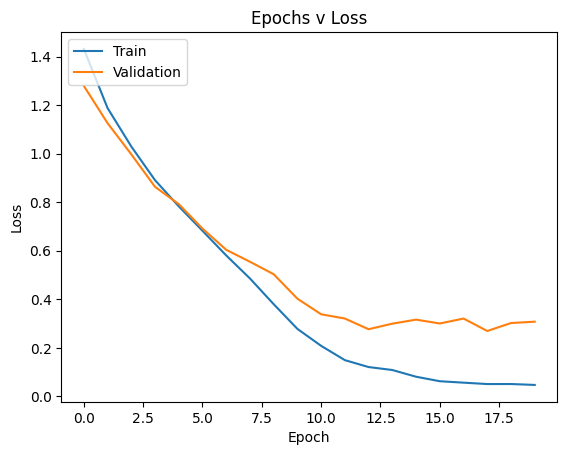

31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 569ms/step - accuracy: 0.9899 - loss: 0.0632
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - accuracy: 0.9376 - loss: 0.2755

Train Accuracy: 0.99
Validation Accuracy: 0.92


In [13]:
tf.random.set_seed(1234)
np.random.seed(1234)

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(layers.Conv3D(
  filters=8,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1',
  activation='relu'
))

# add max pooling layer
model_tf.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
model_tf.add(layers.Dropout(rate=0.2))

# add a flattening layer
model_tf.add(layers.Flatten())

# add a Dense Layer
model_tf.add(layers.Dense(units=32, activation='relu'))

# add the classification layer
model_tf.add(layers.Dense(units=classes, activation='softmax')) #4 classes (softmax for multi-class)

# build and compile model
model_tf.build(input_shape=(None, 32, 32, 32, 1))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
model_tf.summary()

# train model_tf on (X_train, y_train) data
history = model_tf.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=20,
    callbacks=[early_stopping]
)

# plot loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = model_tf.evaluate(X_train, y_train_encoded, verbose=1)
val_loss, val_acc = model_tf.evaluate(X_val, y_val_encoded, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Evaluating Model on Test Data

In [14]:
test_loss, test_acc = model_tf.evaluate(X_test, y_test_encoded, verbose=1)

print(f"\nTest Accuracy: {test_acc:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 537ms/step - accuracy: 0.8918 - loss: 0.3173

Test Accuracy: 0.89


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 591ms/step


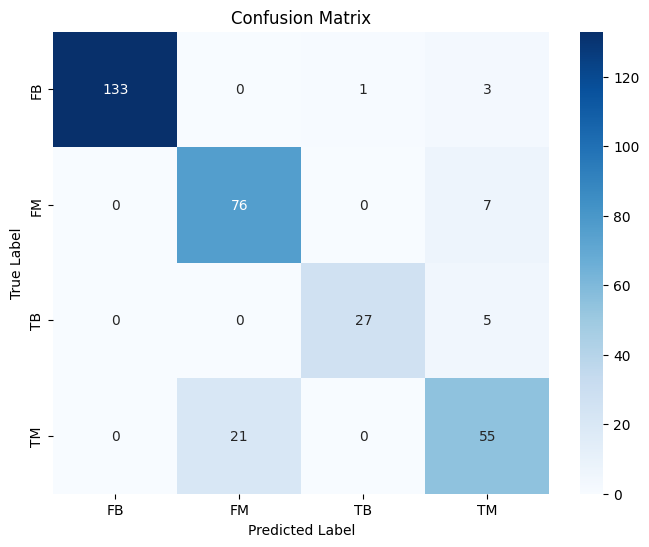


Classification Report:
              precision    recall  f1-score   support

          FB       1.00      0.97      0.99       137
          FM       0.78      0.92      0.84        83
          TB       0.96      0.84      0.90        32
          TM       0.79      0.72      0.75        76

    accuracy                           0.89       328
   macro avg       0.88      0.86      0.87       328
weighted avg       0.89      0.89      0.89       328



In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the test set
y_pred_probs = model_tf.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=class_names))